# Logistic Regression - Toxic Comments Classification

## Objetivo
Implementar y evaluar un modelo de regresión logística para clasificar comentarios tóxicos.

In [53]:
# === 1. Import libraries and basic configuration ============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve)
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [54]:
# -----------------------------
# 2. Load preprocessed dataset
# -----------------------------
data_path = "../../data/preprocessing_data/youtoxic_english_1000_clean.csv"
df = pd.read_csv(data_path)

print(f"✅ Dataset cargado: {len(df)} filas, {len(df.columns)} columnas")
print(f"📊 Columnas disponibles: {list(df.columns)}")
print(f"📊 Distribución target: \n{df['IsToxic'].value_counts()}")

# Verificar datos faltantes
print(f"\n📊 Datos faltantes:")
print(df.isnull().sum())

# Mostrar muestra de datos
print(f"\n📝 Muestra de datos:")
df.head()

✅ Dataset cargado: 997 filas, 18 columnas
📊 Columnas disponibles: ['CommentId', 'VideoId', 'Text', 'IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsReligiousHate', 'text_basic', 'text_classic', 'text_len_classic', 'word_count_classic', 'uppercase_ratio', 'exclamation_count', 'hate_words_count']
📊 Distribución target: 
IsToxic
False    538
True     459
Name: count, dtype: int64

📊 Datos faltantes:
CommentId             0
VideoId               0
Text                  0
IsToxic               0
IsAbusive             0
IsThreat              0
IsProvocative         0
IsObscene             0
IsHatespeech          0
IsRacist              0
IsReligiousHate       0
text_basic            0
text_classic          0
text_len_classic      0
word_count_classic    0
uppercase_ratio       0
exclamation_count     0
hate_words_count      0
dtype: int64

📝 Muestra de datos:


,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsReligiousHate,text_basic,text_classic,text_len_classic,word_count_classic,uppercase_ratio,exclamation_count,hate_words_count
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,If only people would just take a step back and...,people would take step back make case wasnt an...,850,129,0.014121,0,2
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,Law enforcement is not trained to shoot to app...,law enforcement trained shoot apprehend traine...,90,13,0.036232,0,3
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\r\nDont you reckon them 'black lives matter' ...,True,True,False,False,True,False,False,False,Dont you reckon them 'black lives matter' bann...,dont reckon black life matter banner held whit...,252,40,0.002375,0,1
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,There are a very large number of people who do...,large number people like police officer called...,339,49,0.015464,0,0
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,"The Arab dude is absolutely right, he should h...",arab dude absolutely right shot extra time sho...,138,23,0.020576,0,1


In [55]:
# -----------------------------
# 3. Prepare features and target
# -----------------------------
# Target y features
text_col = "text_classic"
num_features = [
    "text_len_classic",
    "word_count_classic", 
    "uppercase_ratio",
    "exclamation_count",
    "hate_words_count"
]

# Verificar que todas las columnas existen
missing_cols = [col for col in [text_col] + num_features if col not in df.columns]
if missing_cols:
    print(f"❌ Columnas faltantes: {missing_cols}")
    print(f"📊 Columnas disponibles: {list(df.columns)}")
else:
    print("✅ Todas las columnas necesarias están disponibles")

# Preparar X e y
X = df[[text_col] + num_features]
y = df["IsToxic"]

print(f"\n📊 Forma de X: {X.shape}")
print(f"📊 Forma de y: {y.shape}")
print(f"📊 Distribución de y: {y.value_counts(normalize=True)}")

✅ Todas las columnas necesarias están disponibles

📊 Forma de X: (997, 6)
📊 Forma de y: (997,)
📊 Distribución de y: IsToxic
False    0.539619
True     0.460381
Name: proportion, dtype: float64


In [56]:
# -----------------------------
# 2. Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

In [57]:
# -----------------------------
# 3. Build pipeline
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", TfidfVectorizer(
            ngram_range=(1,2),       # unigrams + bigramas
            max_features=5000,       # controla tamaño del vocabulario
            min_df=2,                # descarta términos muy raros
            max_df=0.9               # descarta términos demasiado frecuentes
        ), text_col),
        ("num", "passthrough", num_features)
    ]
)

model = Pipeline([
    ("preprocess", preprocessor),
    ("svd", TruncatedSVD(n_components=100)),  
    ("clf", LogisticRegression(C=0.1, max_iter=300, class_weight="balanced"))
])



In [58]:
# -----------------------------
# 4. Train model
# -----------------------------
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('svd', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [59]:
# -----------------------------
# 5. Predictions and metrics
# -----------------------------

# === PREDICCIONES EN TEST ===
y_prob = model.predict_proba(X_test)[:, 1]

# Nuevo threshold
# Se elige un umbral de 0.40 en lugar del valor por defecto (0.5) para optimizar el recall en la detección de contenido tóxico, priorizando la identificación de casos positivos aunque implique menor precisión. Este valor fue seleccionado tras analizar el desempeño en el conjunto de validación.
threshold = 0.40

# Predicciones ajustadas con el nuevo threshold
y_pred = (y_prob >= threshold).astype(int)

# Métricas en TEST
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob)
}

# === PREDICCIONES EN TRAIN (para calcular overfitting) ===
y_train_prob = model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_prob >= threshold).astype(int)

# Métricas en TRAIN
metrics_train = {
    "accuracy_train": accuracy_score(y_train, y_train_pred),
    "precision_train": precision_score(y_train, y_train_pred),
    "recall_train": recall_score(y_train, y_train_pred),
    "f1_train": f1_score(y_train, y_train_pred),
    "roc_auc_train": roc_auc_score(y_train, y_train_prob)
}

# =============================
# Cálculo del overfitting (gap)
# =============================
overfitting_gap = metrics_train["f1_train"] - metrics["f1"]

print("📊 MÉTRICAS EN ENTRENAMIENTO:")
for metric, value in metrics_train.items():
    print(f"   {metric}: {value:.4f}")

print("\n📊 MÉTRICAS EN TEST:")
for metric, value in metrics.items():
    print(f"   {metric}: {value:.4f}")

print(f"\n📏 Overfitting (F1 train - F1 test): {overfitting_gap:.4f}")

# Validación del umbral solicitado (< 5%)
if overfitting_gap < 0.05:
    print("✅ El modelo cumple con el requisito: overfitting < 5%")
else:
    print("⚠️ El modelo NO cumple: overfitting >= 5%")


📊 MÉTRICAS EN ENTRENAMIENTO:
   accuracy_train: 0.6324
   precision_train: 0.5661
   recall_train: 0.8638
   f1_train: 0.6839
   roc_auc_train: 0.7740

📊 MÉTRICAS EN TEST:
   accuracy: 0.6150
   precision: 0.5524
   recall: 0.8587
   f1: 0.6723
   roc_auc: 0.7780

📏 Overfitting (F1 train - F1 test): 0.0116
✅ El modelo cumple con el requisito: overfitting < 5%


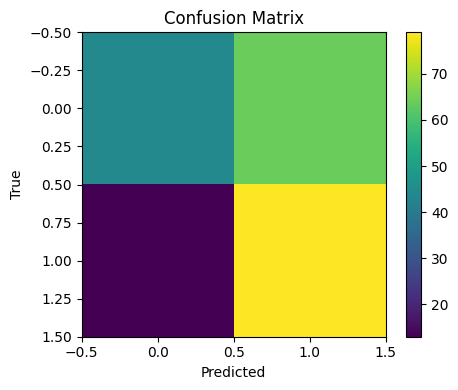

In [60]:
# -----------------------------
# 6. Confusion Matrix Plot
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

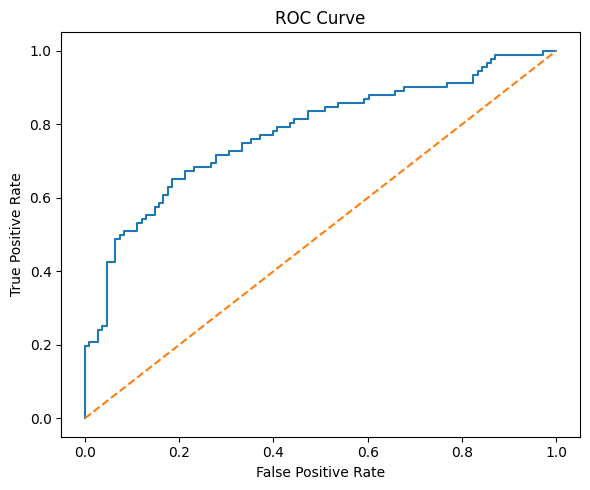

In [61]:
# -----------------------------
# 7. ROC Curve
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.tight_layout()
plt.show()

In [62]:
# -----------------------------
# 8. Save model
# -----------------------------
os.makedirs("backend/models", exist_ok=True)
model_path = "backend/models/logistic_regression.pkl"
joblib.dump(model, model_path)

['backend/models/logistic_regression.pkl']

In [63]:
# -----------------------------
# 9. Save metrics JSON
# -----------------------------
from pathlib import Path
from datetime import datetime
import os

# Usar ruta absoluta basada en el directorio actual
current_dir = Path(os.getcwd())

# Navegar hacia la raíz del proyecto (desde notebooks hacia proyecto)
if "notebooks" in str(current_dir):
    project_root = current_dir.parent.parent  # backend/notebooks -> backend -> proyecto
else:
    project_root = current_dir

model_name = "logistic_regression"
target_col = "IsToxic"
random_state = 42

# Directories for models and results
models_dir = project_root / "backend" / "models"
results_dir = project_root / "data" / "results"

# Crear directorios si no existen
models_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)
print("✅ Directorios creados/verificados")

# Get feature counts from trained model
text_vectorizer = model.named_steps["preprocess"].named_transformers_["tfidf"]
n_features_text = len(text_vectorizer.get_feature_names_out())
n_features_numeric = len(num_features)
n_samples = len(df)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

results_dict = {
    "model_name": model_name,
    "task": "binary_classification",
    "target_label": target_col,
    "data": {
        "n_samples": int(n_samples),
        "n_features_text": int(n_features_text),
        "n_features_numeric": int(n_features_numeric),
        "train_size": float(len(X_train) / n_samples),
        "test_size": float(len(X_test) / n_samples),
        "random_state": int(random_state),
    },
    "metrics": {
        "accuracy": float(metrics["accuracy"]),
        "precision": float(metrics["precision"]),
        "recall": float(metrics["recall"]),
        "f1": float(metrics["f1"]),
        "roc_auc": float(metrics["roc_auc"]),
    },
    "confusion_matrix": {
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
    },
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "notes": "Logistic Regression; TF-IDF + numeric features; max_iter=300",
}

# Paths for saving JSON and model
json_path = results_dir / f"{model_name}.json"
model_path = models_dir / f"{model_name}.pkl"

# Save JSON with error handling
try:
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(results_dict, f, indent=2, ensure_ascii=False)
    print("✅ JSON guardado exitosamente")
except Exception as e:
    print(f"❌ Error guardando JSON: {e}")

# Save model with error handling
try:
    joblib.dump(model, model_path)
    print("✅ Modelo guardado exitosamente")
except Exception as e:
    print(f"❌ Error guardando modelo: {e}")
print("=" * 80)
print("💾 PROCESO DE GUARDADO COMPLETADO")
print("=" * 80)
print(f"\n📊 Métricas finales:")
for metric, value in metrics.items():
    print(f"   {metric}: {value:.4f}")

✅ Directorios creados/verificados
✅ JSON guardado exitosamente
✅ Modelo guardado exitosamente
💾 PROCESO DE GUARDADO COMPLETADO

📊 Métricas finales:
   accuracy: 0.6150
   precision: 0.5524
   recall: 0.8587
   f1: 0.6723
   roc_auc: 0.7780
